In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import lightgbm as lgb

In [2]:
count_2017=pd.read_csv("./data/count_2017.csv")
#此处读取的是处理后的count_2018的数据，因为原数据是有缺失的，需要补齐
count_2018=pd.read_csv("./data/count_2018_update.csv")

In [3]:
#此处读取的是处理后的count_2019，count_2020的数据，因为原数据是有缺失的，需要补齐
count_2019=pd.read_csv("./data/count_2019_update.csv")
count_2020=pd.read_csv("./data/count_2020_update.csv")

In [4]:
sub = pd.read_csv("./data/submit.csv")
to_predict=pd.read_csv("./data/to_predict.csv")

In [5]:
count_train=pd.concat([count_2017,count_2018],axis=0)
count_train=count_train.sort_values(by=['admin_illness_name', 'date']).reset_index(drop=True)

In [6]:
count_test=pd.concat([count_2019,count_2020],axis=0)
count_test=count_test.sort_values(by=['admin_illness_name', 'date']).reset_index(drop=True)

In [7]:
def get_test(df,ids):
    d = df[df["admin_illness_name"]==ids].copy().reset_index(drop=True)
    d1 = d[d["date"]==20190228].reset_index(drop=True)
    d2 = d[d["date"]==20190531].reset_index(drop=True)
    d3 = d[d["date"]==20190831].reset_index(drop=True)
    d4 = d[d["date"]==20191130].reset_index(drop=True)
    d5 = d[d["date"]==20200331].reset_index(drop=True)
    d6 = d[d["date"]==20200630].reset_index(drop=True)
    return pd.concat([d1,d2,d3,d4,d5,d6],axis=0).reset_index(drop=True)

In [8]:
count_train["month"]=count_train["date"].apply(lambda x : int(str(x)[4:6]))
count_train["day"]=count_train["date"].apply(lambda x : int(str(x)[6:8]))
count_test["month"]=count_test["date"].apply(lambda x : int(str(x)[4:6]))
count_test["day"]=count_test["date"].apply(lambda x : int(str(x)[6:8]))

In [9]:
cols=['count']
for j in tqdm(range(1,15)):
    for i in range(len(cols)):
        count_train[cols[i]+'_shifts_'+str(j)]=count_train.groupby(['admin_illness_name'])[cols[i]].shift(j)
        count_test[cols[i]+'_shifts_'+str(j)]=count_test.groupby(['admin_illness_name'])[cols[i]].shift(j)

In [10]:
df_train = pd.DataFrame()
for id_ in tqdm(count_train.admin_illness_name.unique()):
    tmp = count_train[count_train.admin_illness_name == id_].reset_index(drop=True)
    tmp['count_1'] = tmp['count'].shift(-1)
    tmp['count_2'] = tmp['count'].shift(-2)
    tmp['count_3'] = tmp['count'].shift(-3)
    tmp['count_4'] = tmp['count'].shift(-4)
    tmp['count_5'] = tmp['count'].shift(-5)
    tmp['count_6'] = tmp['count'].shift(-6)
    tmp['count_7'] = tmp['count'].shift(-7)
    tmp['count_8'] = tmp['count'].shift(-8)
    tmp['count_9'] = tmp['count'].shift(-9)
    tmp['count_10'] = tmp['count'].shift(-10)
    tmp['count_11'] = tmp['count'].shift(-11)
    tmp['count_12'] = tmp['count'].shift(-12)
    tmp['count_13'] = tmp['count'].shift(-13)
    tmp['count_14'] = tmp['count'].shift(-14)
    df_train = df_train.append(tmp)

In [11]:
df_train =df_train.dropna().reset_index(drop=True)
count_test=count_test.dropna().reset_index(drop=True)

In [12]:
target_cols = ['count_'+str(i) for i in range(1,15)]
feats_cols = [col for col in df_train.columns if col not in target_cols+["admin_illness_name","date"]]

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
def run_lgb(df_train, df_test,target,col):
    model = lgb.LGBMRegressor(n_estimators=100000,random_state=1212)
    oof = np.zeros(df_train.shape[0])
    preds = np.zeros(df_test.shape[0])
    
    kfold = KFold(n_splits=5,shuffle=True, random_state=1212)
    for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train,target)):
        
        X_train = df_train.iloc[trn_idx]
        Y_train = target.iloc[trn_idx][col]
        X_val = df_train.iloc[val_idx]
        Y_val = target.iloc[val_idx][col]
        lgb_model = model.fit(X_train, 
                              Y_train,
                              eval_names=['train', 'valid'],
                              eval_set=[(X_train, Y_train), (X_val, Y_val)],
                              verbose=0,
                              eval_metric='mse',
                              early_stopping_rounds=50)
        oof[val_idx] = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)
        preds += lgb_model.predict(df_test, num_iteration=lgb_model.best_iteration_)/5
    score = mean_squared_error(oof, target[col]) 
    return oof, preds,score

In [14]:
import warnings
warnings.filterwarnings('ignore')
scores1=[]
sub=pd.DataFrame()
s=0
for qid in count_test.admin_illness_name.unique():
    scores2=[]
    test_x=get_test(count_test,qid)
    x_id = df_train[(df_train.admin_illness_name == qid)][feats_cols]
    t_id = test_x[feats_cols]
    y_id = df_train[(df_train.admin_illness_name == qid)][target_cols]
    for col in target_cols:
        oof, preds, score=run_lgb(x_id, t_id, y_id,col)
        test_x[col]=preds
        scores1.append(score)
        scores2.append(score)
    sub = pd.concat([sub,test_x],axis=0)
    print(x_id.shape,t_id.shape,y_id.shape)
    print(s,'------','admin_illness_name:',qid)
    print(np.mean(scores2))
    s+=1
print(np.mean(scores1))

(702, 17) (6, 17) (702, 14)
0 ------ admin_illness_name: 上呼吸道感染
114.4927159915786
(94, 17) (6, 17) (94, 14)
1 ------ admin_illness_name: 上呼吸道疾病
297.2813904293511
(396, 17) (6, 17) (396, 14)
2 ------ admin_illness_name: 丘疹性荨麻疹
23.045888033831506
(594, 17) (6, 17) (594, 14)
3 ------ admin_illness_name: 中耳炎
56.30225008381696
(680, 17) (6, 17) (680, 14)
4 ------ admin_illness_name: 发热
1123.9102823319608
(80, 17) (6, 17) (80, 14)
5 ------ admin_illness_name: 变应性鼻炎
61.90167955626206
(624, 17) (6, 17) (624, 14)
6 ------ admin_illness_name: 呕吐
81.0855340873281
(690, 17) (6, 17) (690, 14)
7 ------ admin_illness_name: 呼吸道感染
122.82804015275589
(698, 17) (6, 17) (698, 14)
8 ------ admin_illness_name: 咳嗽
400.43860960511853
(570, 17) (6, 17) (570, 14)
9 ------ admin_illness_name: 哮喘
169.42755072743128
(698, 17) (6, 17) (698, 14)
10 ------ admin_illness_name: 外伤证
107.834847018348
(702, 17) (6, 17) (702, 14)
11 ------ admin_illness_name: 头晕
21.594170675667545
(690, 17) (6, 17) (690, 14)
12 ------ admi

In [15]:
sub

,date,admin_illness_name,count,month,day,count_shifts_1,count_shifts_2,count_shifts_3,count_shifts_4,count_shifts_5,...,count_5,count_6,count_7,count_8,count_9,count_10,count_11,count_12,count_13,count_14
0,20190228,上呼吸道感染,35.0,2,28,37.0,50.0,63.0,46.0,40.0,...,39.034538,34.204763,32.608733,32.906032,30.362302,37.000872,37.500367,32.845910,29.313137,27.947554
1,20190531,上呼吸道感染,88.0,5,31,47.0,66.0,82.0,85.0,91.0,...,40.507024,44.591144,43.241562,36.426485,33.737733,38.012529,36.762834,33.923896,30.956122,30.864700
2,20190831,上呼吸道感染,66.0,8,31,125.0,93.0,77.0,93.0,100.0,...,41.645976,44.747064,43.593038,36.685259,33.737733,38.012529,36.451217,33.759105,31.146944,30.864700
3,20191130,上呼吸道感染,118.0,11,30,119.0,112.0,112.0,87.0,122.0,...,56.649163,59.948451,59.827116,59.376260,57.476475,58.988084,57.676347,56.835250,56.642161,58.372953
4,20200331,上呼吸道感染,29.0,3,31,55.0,62.0,70.0,66.0,44.0,...,40.716942,43.830869,32.254801,34.905614,31.715163,37.741164,35.942152,32.306922,30.267719,28.902187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,20190531,荨麻疹,14.0,5,31,15.0,15.0,24.0,25.0,19.0,...,19.536137,19.985792,19.527909,20.723194,21.371063,21.637153,22.128459,19.092823,19.272648,20.577501
2,20190831,荨麻疹,25.0,8,31,26.0,34.0,36.0,16.0,31.0,...,22.571900,23.570803,26.406694,25.367899,24.478557,22.667659,20.385878,21.848215,19.889440,20.060154
3,20191130,荨麻疹,21.0,11,30,14.0,18.0,25.0,25.0,18.0,...,20.648558,16.512609,15.342662,18.436414,20.423220,16.423418,17.146491,17.459530,16.054289,14.919480
4,20200331,荨麻疹,5.0,3,31,6.0,7.0,9.0,6.0,7.0,...,5.566125,5.482150,9.001610,5.808987,4.829786,3.653544,4.872577,6.958427,7.769379,9.594483


In [16]:
to_predict["count"]=0

In [17]:
for c in sub.admin_illness_name.unique():
    a=sub.loc[sub['admin_illness_name']==c,target_cols].values.flatten()
    to_predict.loc[to_predict['admin_illness_name']==c,"count"]=a

In [18]:
to_predict['count']=to_predict['count'].astype(int)

In [19]:
to_predict[["id","count"]].to_csv("./result/submit_{}.csv".format(round(np.mean(scores1),6)),index=False)

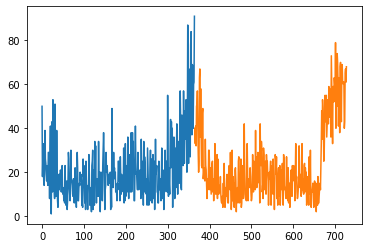

In [30]:
import matplotlib.pyplot as plt

plt.plot(list(range(365)),a)
plt.plot(list(range(365,365+363)),b)
plt.show()